<a href="https://colab.research.google.com/github/abhisheksambyal/Class_Activation_Maps/blob/master/06_Class_Activation_Map.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## http://cnnlocalization.csail.mit.edu/Zhou_Learning_Deep_Features_CVPR_2016_paper.pdf

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler

import torchvision
from torchvision import transforms
import torchvision.models as models

from PIL import Image
import numpy as np
import random
import os
import matplotlib.pyplot as plt
import copy

In [ ]:
!pip install kaggle

#upload Kaggle Credentials
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle

!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# !kaggle config set -n path -v /content 
# !kaggle config view

# Dogs Dataset

In [ ]:
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition

 96% 261M/271M [00:03<00:00, 50.5MB/s]
100% 271M/271M [00:03<00:00, 73.4MB/s]
100% 544M/544M [00:04<00:00, 117MB/s]

  0% 0.00/111k [00:00<?, ?B/s]
100% 111k/111k [00:00<00:00, 104MB/s]


In [ ]:
!ls competitions/dogs-vs-cats-redux-kernels-edition/
!unzip competitions/dogs-vs-cats-redux-kernels-edition/train.zip
!unzip competitions/dogs-vs-cats-redux-kernels-edition/test.zip

In [ ]:
!ls train

In [ ]:
PATH = 'train'

In [ ]:
class DogsCatsDataset(Dataset):
  def __init__(self, PATH, transform=None):
    self.images = os.listdir(PATH)
    self.transform = transform
    cat, dog = [], []
    [cat.append(i) if i[0]=='c' else dog.append(i) for i in self.images]
#     print(len(random.sample(cat, 5000)), len(dog))
    self.images = random.sample(cat, 2500) + random.sample(dog, 2500)
#     print(len(self.images))

  def __getitem__(self, idx):
    if self.images[idx][0] == 'c':
      label = 0
    else:
      label = 1
    
    image = Image.open(os.path.join(PATH, self.images[idx]))
    
    if self.transform:
      image = self.transform(image)
      
    return image, label
  
  def __len__(self):
    return len(self.images)
  
traindataset = DogsCatsDataset(PATH, transform=transform)

In [ ]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
# normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
#     transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize])

In [ ]:
traindataset = DogsCatsDataset(PATH, transform=transform)

In [ ]:
# bs = 32

# traindataset = torchvision.datasets.CIFAR10(root='./CIFAR10', download=True, train=True, transform=transform)
# testdataset = torchvision.datasets.CIFAR10(root='./CIFAR10', download=True, train=True, transform=transform)

# trainloader = DataLoader(traindataset, batch_size=bs, shuffle=True)
# testloader = DataLoader(testdataset, batch_size=bs, shuffle=True)

## Create Validation Dataset

In [ ]:
# percentage of training set to use as validation
valid_size = 0.2

# obtain training indices that will be used for validation
num_train = len(traindataset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]
# print(train_idx, valid_idx)

In [ ]:
print(len(traindataset), len(train_idx), len(valid_idx))

5000 4000 1000


In [ ]:
# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [ ]:
bs = 32

trainloader = DataLoader(traindataset, batch_size=bs, sampler=train_sampler)
testloader = DataLoader(traindataset, batch_size=bs, sampler=valid_sampler)

# continue

In [ ]:
print(len(trainloader))

125


In [ ]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.shape, labels.shape)

torch.Size([32, 3, 224, 224]) torch.Size([32])


In [ ]:
print(labels)

tensor([1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1,
        1, 0, 1, 1, 1, 1, 0, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


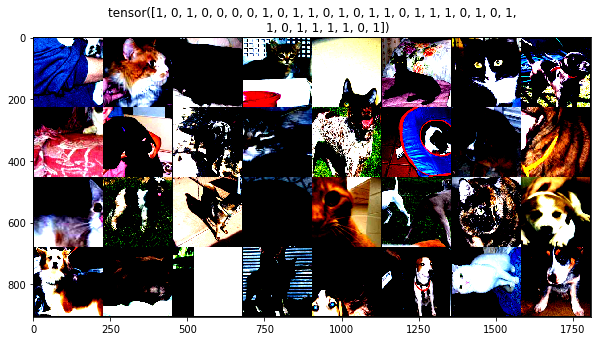

In [ ]:
def imshow(img, title=None):
#     img = img / 2 + 0.5     # unnormalize
  npimg = img.cpu().detach().numpy()
  plt.figure(figsize=(10, 10))
  plt.title(title)

  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.grid(b=False)
  plt.show()

# show images
imshow(torchvision.utils.make_grid(images), title=str(labels))
# imshow(torchvision.utils.make_grid(labels))

In [ ]:
# get some random training images
dataiter = iter(testloader)
images, labels = dataiter.next()
print(images.shape, labels.shape)

torch.Size([32, 3, 224, 224]) torch.Size([32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


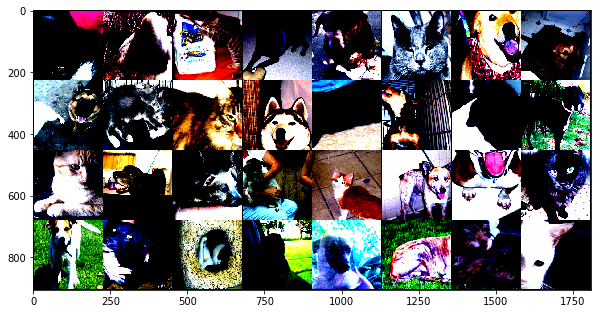

In [ ]:
# show images
imshow(torchvision.utils.make_grid(images))

# Model

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
net = models.vgg16(pretrained=True)
net.classifier[6] = nn.Linear(4096, 10)

net.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

# Optimization Technique

In [ ]:
l_r = 1e-3
criterion = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr = l_r, momentum=0.9)

# Training as Classifier

In [ ]:
epochs = 5

# for epoch in tqdm_notebook(range(epochs)):
for epoch in range(epochs):
  runningloss = 0
  
  for images, labels in trainloader:
    net.train()
    images, labels = Variable(images).to(device), Variable(labels).to(device)  
  
    optimizer.zero_grad()  # zeroes the gradient buffers of all parameters
    outputs = net(images) # forward 
    loss = criterion(F.log_softmax(outputs, dim=1), labels) # calculate loss
    loss.backward() #  backpropagate the loss
    optimizer.step()
    runningloss += loss.item()
    
  else:
    net.eval()
    correct = 0
    with torch.no_grad():
      for data in testloader:
        inputs, labels = data
        images, labels = Variable(inputs).to(device), labels.to(device)
        
        outputs = net(images)
        _, predicted = torch.max(F.log_softmax(outputs, dim=1), 1)
        correct += torch.sum(predicted==labels).item()
    accuracy = correct / len(testloader.dataset)
  print('At Iteration : %d / %d  ;  Train Error : %f ;Test Accuracy : %f'%(epoch+1, epochs, runningloss/len(testloader), accuracy))
print('Finished Training')


At Iteration : 1 / 5  ;  Train Error : 0.406159 ;Test Accuracy : 0.191800
At Iteration : 2 / 5  ;  Train Error : 0.366416 ;Test Accuracy : 0.192200
At Iteration : 3 / 5  ;  Train Error : 0.338903 ;Test Accuracy : 0.194000
At Iteration : 4 / 5  ;  Train Error : 0.340596 ;Test Accuracy : 0.192400
At Iteration : 5 / 5  ;  Train Error : 0.305205 ;Test Accuracy : 0.188200
Finished Training


In [ ]:
conv_net = nn.Sequential(*list(net.children())[:-2])
print(conv_net)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, ker

In [ ]:
out = conv_net(images[0].unsqueeze(0))

In [ ]:
weights = copy.deepcopy(net.fc.weight.data.cpu()).numpy()
print(weights.shape)

(10, 512)


In [ ]:
out_np = out.squeeze(0)
print(out_np.shape)

torch.Size([512, 7, 7])


In [ ]:
mask1 = np.ones(out_np.shape)
print(mask1.shape)

(512, 7, 7)


In [ ]:
for n1 in range(512):
  mask1[n1] = weights[0, n1] * mask1[n1]
  
outImg1 = np.sum(np.multiply(out_np.detach().cpu().numpy(), mask1), axis=0)

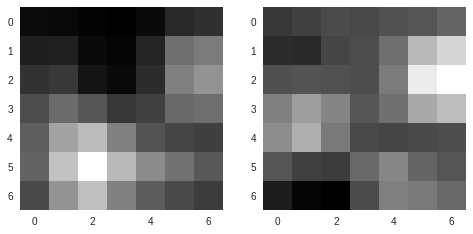

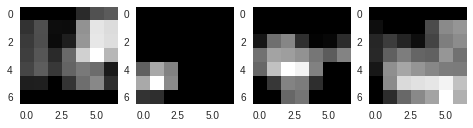

In [ ]:
# Averaged activation map
plt.figure()
plt.subplot(121)
plt.imshow(np.sum(out_np.detach().cpu().numpy(), axis=0)/512,cmap='gray')
plt.grid(b=False)
# Weighted-sum activation map
plt.subplot(122)
plt.imshow(outImg1,cmap='gray')
plt.grid(b=False)
# Activation maps chosen at random
plt.figure()
randIdx = np.random.randint(0,511,4)
plt.subplot(141)
plt.grid(b=False)
plt.imshow(out_np[randIdx[0]].detach().cpu().numpy(),cmap='gray')
plt.subplot(142)
plt.grid(b=False)
plt.imshow(out_np[randIdx[1]].detach().cpu().numpy(),cmap='gray')
plt.subplot(143)
plt.grid(b=False)
plt.imshow(out_np[randIdx[2]].detach().cpu().numpy(),cmap='gray')
plt.subplot(144)
plt.grid(b=False)
plt.imshow(out_np[randIdx[3]].detach().cpu().numpy(),cmap='gray')
plt.grid(b=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


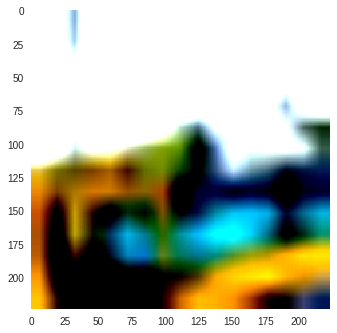

In [ ]:
def imshow(img, title=None):
#     img = img / 2 + 0.5     # unnormalize
  npimg = img.cpu().detach().numpy()
#   plt.figure(figsize=(10, 10))
  plt.title(title)

  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.grid(b=False)
  plt.show()


imshow(torchvision.utils.make_grid(images[0].unsqueeze(0)))
# plt.imshow(images[0].detach().cpu().numpy())

# Testing Performance

In [ ]:
classes = ('zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine')

class_correct = np.array([0.] * 10)
class_total = np.array([0.] * 10)
for data in testloader:
    images, labels = data
    if GPU:
        outputs = net(Variable(images.view(-1, 28*28).cuda()))
        _, predicted = torch.max(outputs.cpu(), 1)
    else:
        outputs = net(Variable(images.view(-1, 28*28)))
        _, predicted = torch.max(outputs, 1)
    c = (predicted == labels)
    for i in range(bs):
        label = labels[i].item()
        class_correct[label] += c[i].item()
        class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %f %%' % (classes[i], 100 * class_correct[i] / float(class_total[i])))

Accuracy of  zero : 97.653061 %
Accuracy of   one : 97.268722 %
Accuracy of   two : 86.143411 %
Accuracy of three : 88.910891 %
Accuracy of  four : 91.955193 %
Accuracy of  five : 82.511211 %
Accuracy of   six : 92.588727 %
Accuracy of seven : 89.980545 %
Accuracy of eight : 85.831622 %
Accuracy of  nine : 87.413280 %


# CIFAR Dataset

In [ ]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
# normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])

transform = transforms.Compose([
#     transforms.RandomResizedCrop(224),
    transforms.Resize(224),
    transforms.ToTensor(),
    normalize])

In [ ]:
bs = 32

traindataset = torchvision.datasets.CIFAR10(root='./CIFAR10', download=True, train=True, transform=transform)
testdataset = torchvision.datasets.CIFAR10(root='./CIFAR10', download=True, train=False, transform=transform)

trainloader = DataLoader(traindataset, batch_size=bs, shuffle=True)
testloader = DataLoader(testdataset, batch_size=bs, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.shape, labels.shape)

torch.Size([32, 3, 224, 224]) torch.Size([32])


In [ ]:
print(labels)

tensor([3, 5, 1, 4, 0, 6, 8, 8, 0, 6, 7, 2, 2, 8, 6, 6, 4, 2, 0, 5, 1, 6, 6, 5,
        3, 1, 2, 5, 4, 0, 1, 0])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


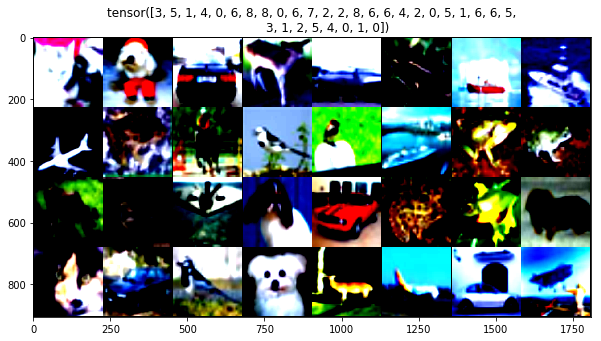

In [ ]:
def imshow(img, title=None):
#     img = img / 2 + 0.5     # unnormalize
  npimg = img.cpu().detach().numpy()
  plt.figure(figsize=(10, 10))
  plt.title(title)

  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.grid(b=False)
  plt.show()

# show images
imshow(torchvision.utils.make_grid(images), title=str(labels))
# imshow(torchvision.utils.make_grid(labels))

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# VGG

In [ ]:
net = models.vgg16(pretrained=True)
net

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [ ]:
# Learned new way of initilizing
# class Identity(nn.Module):
#     def __init__(self):
#         super(Identity, self).__init__()
# #         avg = nn.AdaptiveAvgPool2d((1, 1))
        
#     def forward(self, x):
# #       x = avg(x)
#       return x

# net.avgpool = Identity()

In [ ]:
net.avgpool = nn.AvgPool2d(7)

In [ ]:
net.classifier = nn.Sequential(nn.Linear(512, 10), nn.LogSoftmax(dim=1))
net.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [ ]:
l_r = 1e-2
criterion = nn.NLLLoss()
# optimizer = optim.SGD(net.parameters(), lr = l_r, momentum=0.9)
optimizer = optim.SGD(net.parameters(), lr = l_r)

In [ ]:
def run(epochs=5):

  # for epoch in tqdm_notebook(range(epochs)):
  for epoch in range(epochs):
    runningloss = 0

    for images, labels in trainloader:
      net.train()
      images, labels = Variable(images).to(device), Variable(labels).to(device)  

      optimizer.zero_grad()  # zeroes the gradient buffers of all parameters
      outputs = net(images) # forward 
      loss = criterion(outputs, labels) # calculate loss
  #     print('output', outputs)
  #     print('labels', labels)
  #     print('loss1', loss)
      loss.backward() #  backpropagate the loss
      optimizer.step()
  #     print('loss', loss.item())
  #     break
      runningloss += loss.item()

    else:
      net.eval()
      correct = 0
      with torch.no_grad():
        for data in testloader:
          inputs, labels = data
          images, labels = Variable(inputs).to(device), labels.to(device)

          outputs = net(images)
          _, predicted = torch.max(outputs, 1)
          correct += torch.sum(predicted==labels).item()
      accuracy = correct / len(testloader.dataset)
    print('At Iteration : %d / %d  ;  Train Error : %f ;Test Accuracy : %f'%(epoch+1, epochs, runningloss/len(testloader), accuracy))
  print('Finished Training')

In [ ]:
run(epochs=1)
%time

At Iteration : 1 / 1  ;  Train Error : 2.769374 ;Test Accuracy : 0.833300
Finished Training
CPU times: user 1e+03 ns, sys: 2 µs, total: 3 µs
Wall time: 5.96 µs


In [ ]:
for epoch in range(2):
    runningloss = 0

    for images, labels in trainloader:
      net.train()
      images, labels = Variable(images).to(device), Variable(labels).to(device)  
      outputs = net.features(images)
      print('features', outputs.shape)
      outputs = net.avgpool(outputs)
      print('avgpool', outputs.shape)
      outputs = net.classifier(outputs.view(-1, 1*1*512))
      print(outputs.shape)
      
      outputs = net(images) # forward
      print(outputs.shape)
      break
    break

features torch.Size([32, 512, 7, 7])
avgpool torch.Size([32, 512, 1, 1])
torch.Size([32, 10])
torch.Size([32, 10])


In [ ]:
print('last conv layer:', net.features[28].weight.data.shape)
print('weights: ', net.classifier[0].weight.data.shape)

last conv layer: torch.Size([512, 512, 3, 3])
weights:  torch.Size([10, 512])


In [ ]:
o = net(images[0].unsqueeze(0).cuda())
l = labels[0].item()
print('label', l, ';output label:', torch.max(o, 1)[1].item())
# print(o.shape)
# print(o)
print('weights: ', net.classifier[0].weight[l].data.shape)
# print('weights: ', net.classifier[0].weight[l].data)

label 8 ;output label: 8
weights:  torch.Size([512])


In [ ]:
x = images[0].unsqueeze(0).cuda()
print(x.shape)
c = 0
modulelist = list(net.features.modules())
for l in modulelist[0][:28]:
  print(c, end=' ')
  c+=1
  if c > 27:
    print(x.shape)
  x = l(x)
#   print(x.shape)
keep = x
print('{}: {}'.format(c, keep.shape))
for l in modulelist[29:]:
  print(c, end=' ')
  c+=1
  if c > 27:
    print(x.shape)
  x = l(x)

torch.Size([1, 3, 224, 224])
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 torch.Size([1, 512, 14, 14])
28: torch.Size([1, 512, 14, 14])
28 torch.Size([1, 512, 14, 14])
29 torch.Size([1, 512, 14, 14])
30 torch.Size([1, 512, 14, 14])


In [ ]:
x = images[0].unsqueeze(0).cuda()
c = 0
modulelist = list(net.features.modules())
for l in modulelist[0][:28]:
  x = l(x)
keep = x
print('{}'.format(keep.shape))

torch.Size([1, 512, 14, 14])


In [ ]:
print(keep.shape)
print('weights: ', net.classifier[0].weight.data.shape)
print('weights {} ; label {} ; label weights{} '.format(net.classifier[0].weight.data.shape, 
                                       labels[0], 
                                       net.classifier[0].weight[labels[0]].data.shape))

torch.Size([1, 512, 14, 14])
weights:  torch.Size([10, 512])
weights torch.Size([10, 512]) ; label 8 ; label weightstorch.Size([512]) 


In [ ]:
print(keep.shape)
print(net.classifier[0].weight[labels[0]].data.unsqueeze(1).unsqueeze(1).unsqueeze(0).shape)

torch.Size([1, 512, 14, 14])
torch.Size([1, 512, 1, 1])


In [ ]:
tt = torch.mul(keep, net.classifier[0].weight[labels[0]].data.unsqueeze(1).unsqueeze(1).unsqueeze(0))
print('tt: ',tt.shape)

tt_sum = torch.sum(tt, dim=1)
print('tt_sum: ', tt_sum.shape)

from skimage.transform import resize
tt_resized = resize(tt_sum[0].detach().cpu().numpy(), (224, 224), anti_aliasing=True)

print('tt_resized: ', tt_resized.shape)

tt:  torch.Size([1, 512, 14, 14])
tt_sum:  torch.Size([1, 14, 14])
tt_resized:  (224, 224)


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [ ]:
# show images
imshow(torchvision.utils.make_grid(images[0].unsqueeze(0)), title=str(labels[0]))
# imshow(torchvision.utils.make_grid(labels))

imshow(torchvision.utils.make_grid(torch.tensor(tt_resized, dtype=torch.float32).unsqueeze(0).unsqueeze(0)), title=str(labels[0]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


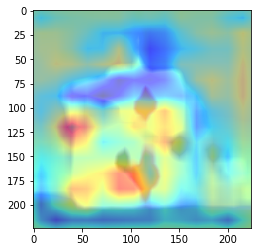

In [ ]:
# plt.xlabel(buf)
plt.imshow(np.transpose(images[0].detach().cpu().numpy(), (1, 2, 0)), alpha=0.5)
plt.imshow(tt_resized, cmap='jet', alpha=0.5)
plt.show() 

In [ ]:
# def imshow(img, title=None):
# #     img = img / 2 + 0.5     # unnormalize
#   npimg = img.cpu().detach().numpy()
#   plt.figure(figsize=(10, 10))
#   plt.title(title)

#   plt.imshow(np.transpose(npimg, (1, 2, 0)))
#   plt.grid(b=False)
#   plt.show()
  

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2)
# f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1 = subplot(1,2,1)
# xticks([]), yticks([])
# title('subplot(1,2,1)')
ax1.imshow(t)

ax2 = subplot(1,2,2)
# xticks([]), yticks([])
# title('subplot(1,2,2)')
ax2.plot(t)

show()


In [ ]:
import warnings
warnings.filterwarnings('ignore')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


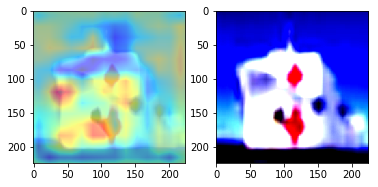

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


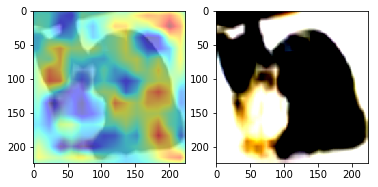

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


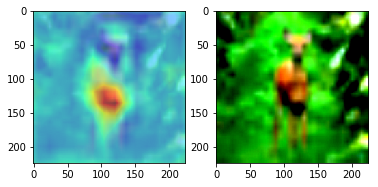

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


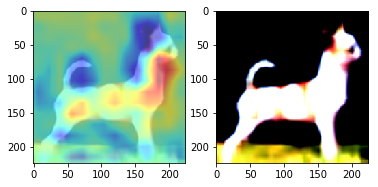

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


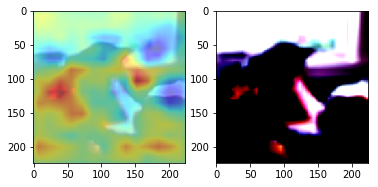

In [ ]:
for i in range(5):
  f, (ax1, ax2) = plt.subplots(1, 2)
  
  x = images[i].unsqueeze(0).cuda()

  modulelist = list(net.features.modules())
  for l in modulelist[0][:28]:
    x = l(x)
  keep = x

  tt = torch.mul(keep, net.classifier[0].weight[labels[i]].data.unsqueeze(1).unsqueeze(1).unsqueeze(0))
  # print('tt: ',tt.shape)

  tt_sum = torch.sum(tt, dim=1)
  # print('tt_sum: ', tt_sum.shape)

  from skimage.transform import resize
  tt_resized = resize(tt_sum[0].detach().cpu().numpy(), (224, 224), anti_aliasing=True)
  # print('tt_resized: ', tt_resized.shape)
  
  # plt.xlabel(buf)
#   plt.imshow(np.transpose(images[i].detach().cpu().numpy(), (1, 2, 0)), alpha=0.5)
#   plt.imshow(tt_resized, cmap='jet', alpha=0.5)
#   plt.show()
  ax1.imshow(np.transpose(images[i].detach().cpu().numpy().astype(np.float32), (1, 2, 0)), alpha=0.5)
  ax1.imshow(tt_resized.astype(np.float32), cmap='jet', alpha=0.5)
  ax2.imshow(np.transpose(images[i].detach().cpu().numpy().astype(np.float32), (1, 2, 0)))
  plt.show()
#   break

# Model

In [ ]:
class CAM(nn.Module):
  def __init__(self):
    super(CAM, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(5,5),  stride=(1,1))
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=64,  kernel_size=(5,5), stride=(1,1))
    self.fc1 = nn.Linear(in_features=5*5*64,  out_features=256)
    self.fc2 = nn.Linear(in_features=256, out_features=10)
    self.softmax = nn.LogSoftmax(dim=1)
    
  def forward(self, x):
    x = self.conv1(x)
#     print('conv1', x.size())
    x = F.relu(x)
    x = F.max_pool2d(x, 2, 2)
#     print('conv1 max pool', x.size())
    x = self.conv2(x)
#     print('conv2', x.size())
    x = F.relu(x)
    x = F.max_pool2d(x, 2, 2)
#     print('conv2 max pool', x.size())
    ########################## feed output to fully connected layer #############
    ## vectorizing the input matrix
    x = x.view(-1, 5*5*64)
    print('flatten1', x.size())
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    x = self.softmax(x)
#     print('flatten2', x.size())
    return x

In [ ]:
class CAM(nn.Module):
  def __init__(self):
    super(CAM, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(5,5),  stride=(1,1))
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=16,  kernel_size=(5,5), stride=(1,1))
#     self.fc1 = nn.Linear(in_features=5*5*64,  out_features=10)
    self.fc1 = nn.Linear(in_features=1*1*16, out_features=10)
    self.softmax = nn.LogSoftmax(dim=1)
    
  def forward(self, x):
    x = self.conv1(x)
#     print('conv1', x.size())
    x = F.relu(x)
    x = F.max_pool2d(x, 2, 2)
#     print('conv1 max pool', x.size())
    x = self.conv2(x)
#     print('conv2', x.size())
    x = F.relu(x)
    x = F.max_pool2d(x, 2, 2)
#     print('conv2 max pool', x.size())

    
    x = torch.mean(x, (2, 3), True)
#     print('mean x', x.size())
    x = x.view(-1, 1*1*16)
#     print('flatten x', x.size())
#     x = x.view(-1, 5*5*64)
#     print('flatten1', x.size())

    x = F.relu(self.fc1(x))
#     print('output', x.size())
    x = self.softmax(x)
    return x

In [ ]:
a = torch.tensor(np.random.random((32, 16, 10, 10)))
print(a.shape)
print(torch.mean(a, (2, 3), True).shape)
# print(torch.mean(a, (2, 3)))

torch.Size([32, 16, 10, 10])
torch.Size([32, 16, 1, 1])


In [ ]:
b = torch.tensor((np.arange(16)*1.).reshape(2, 2, 2, 2))
print(b.shape)
# print(b)

# print(torch.mean(b, 1).shape)
print(b.view(-1, 8))
print(torch.mean(b.view(-1, 8), 1))

torch.Size([2, 2, 2, 2])
tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]], dtype=torch.float64)
tensor([ 3.5000, 11.5000], dtype=torch.float64)


In [ ]:
m = nn.AvgPool2d(10)
a = torch.tensor(np.random.random((32, 16, 10, 10)))
print(m(a).shape)

torch.Size([32, 16, 1, 1])


In [ ]:
m = nn.AvgPool2d(2)
a = torch.tensor([[1, 1], [1, 1]], dtype=torch.float32)
print(m(a).shape)

In [ ]:
net = CAM()
net.to(device)

CAM(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=16, out_features=10, bias=True)
  (softmax): LogSoftmax()
)

In [ ]:
for images, labels in trainloader:
      net.train()
      images, labels = Variable(images).to(device), Variable(labels).to(device)  

#       optimizer.zero_grad()  # zeroes the gradient buffers of all parameters
      outputs = net(images) # forward 
      break

mean x torch.Size([32, 16, 1, 1])
flatten x torch.Size([32, 16])
output torch.Size([32, 10])


In [ ]:
l_r = 1e-2
criterion = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr = l_r, momentum=0.9)
# optimizer = optim.SGD(net.parameters(), lr = l_r)

In [ ]:
def run(epochs=5):

  # for epoch in tqdm_notebook(range(epochs)):
  for epoch in range(epochs):
    runningloss = 0

    for images, labels in trainloader:
      net.train()
      images, labels = Variable(images).to(device), Variable(labels).to(device)  

      optimizer.zero_grad()  # zeroes the gradient buffers of all parameters
      outputs = net(images) # forward 
      loss = criterion(outputs, labels) # calculate loss
  #     print('output', outputs)
  #     print('labels', labels)
  #     print('loss1', loss)
      loss.backward() #  backpropagate the loss
      optimizer.step()
  #     print('loss', loss.item())
  #     break
      runningloss += loss.item()

    else:
      net.eval()
      correct = 0
      with torch.no_grad():
        for data in testloader:
          inputs, labels = data
          images, labels = Variable(inputs).to(device), labels.to(device)

          outputs = net(images)
          _, predicted = torch.max(outputs, 1)
          correct += torch.sum(predicted==labels).item()
      accuracy = correct / len(testloader.dataset)
    print('At Iteration : %d / %d  ;  Train Error : %f ;Test Accuracy : %f'%(epoch+1, epochs, runningloss/len(testloader), accuracy))
  print('Finished Training')


In [ ]:
run(epochs=1)

At Iteration : 1 / 1  ;  Train Error : 9.476143 ;Test Accuracy : 0.427300
Finished Training


In [ ]:
net.conv2.weight.shape

torch.Size([16, 16, 5, 5])

In [ ]:
net.fc1.weight.data.shape

torch.Size([10, 16])

In [ ]:
print(images[0].unsqueeze(0).shape)
print(labels[0])

torch.Size([1, 3, 32, 32])
tensor(5, device='cuda:0')


In [ ]:
o = net(images[0].unsqueeze(0).cuda())
print(o.shape)
print(o)
print(torch.max(o, 1))

torch.Size([1, 10])
tensor([[-8.0991, -9.6417, -5.2609, -1.3973, -6.6532, -0.3076, -6.4975, -5.4612,
         -5.4807, -7.1953]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)
torch.return_types.max(
values=tensor([-0.3076], device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([5], device='cuda:0'))


In [ ]:
temp_x = images[0].unsqueeze(0).cuda()
# print(temp_x.shape)
for name, layer in net._modules.items():
  print(name)
  print('before', temp_x.shape)
  temp_x = layer(temp_x)
  print('after', temp_x.shape)